# Research & Analysis: Simple Chat Performance

**Objective:** To systematically evaluate and compare the performance of different Ollama models in a simple, non-agentic chat scenario.

## 1. Methodology

This experiment will test two primary models:

- `gemma3:1b`
- `qwen3:8b`

We will send a predefined set of questions to the `/api/chat` endpoint. For each question and model combination, we will measure the following **Key Performance Indicators (KPIs)**:

- **Latency:** The time from sending the request to receiving the complete response (in seconds).
- **Success:** A binary metric (1 for success, 0 for failure) indicating whether a non-empty response was received.

## 2. Setup & Dependencies

In [ ]:
# Ensure you have the required libraries installed
%pip install httpx pandas matplotlib seaborn

## 3. Experiment Execution

This experiment compares the baseline performance of our two candidate models.

**Prerequisite:** Ensure the backend server is running (`make run`).

In [3]:
import httpx
import pandas as pd
import time
import json

API_ENDPOINT = "http://localhost:8000/api/chat"
MODELS_TO_TEST = ["gemma3:1b", "qwen3:8b"]
QUESTIONS = [
    {"id": "simple-qa-1", "prompt": "Hello what's up?"},
    {"id": "simple-qa-2", "prompt": "What is your name?"},
    {"id": "simple-qa-3", "prompt": "Write a short, 3-sentence story."}
]

results = []
def run_experiment():
    print("--- Running Simple Chat Performance Experiment ---")
    with httpx.Client(timeout=120.0) as client:
        for model in MODELS_TO_TEST:
            print(f"--- Testing Model: {model} ---")
            for q in QUESTIONS:
                print(f"  > Question: {q['prompt']}")
                payload = {"model": model, "messages": [{"role": "user", "content": q['prompt']}]}
                start_time = time.time()

                try:
                    with client.stream("POST", API_ENDPOINT, json=payload) as response:
                        response.raise_for_status()
                        final_content = ""
                        is_done = False

                        for line in response.iter_lines():
                            if line:
                                data = json.loads(line)
                                # Aggregate content from the message object
                                if "message" in data and "content" in data["message"]:
                                    final_content += data["message"]["content"]
                                # Check for the 'done' flag
                                if data.get("done"):
                                    is_done = True

                        latency = time.time() - start_time
                        success = 1 if final_content and is_done else 0

                        results.append({
                            "model": model,
                            "question_id": q['id'],
                            "latency": latency,
                            "success": success
                        })
                        print(f"    Latency: {latency:.2f}s | Success: {success}")

                except Exception as e:
                    print(f"ERROR: {e}")
                    results.append({"model": model, "question_id": q['id'], "latency": 0, "success": 0})

run_experiment()
df = pd.DataFrame(results)
print("\nExperiment Complete!")
df

--- Running Simple Chat Performance Experiment ---
--- Testing Model: gemma3:1b ---
  > Question: Hello what's up?
    Latency: 2.40s | Success: 1
  > Question: What is your name?
    Latency: 0.89s | Success: 1
  > Question: Write a short, 3-sentence story.
    Latency: 0.86s | Success: 1
--- Testing Model: qwen3:8b ---
  > Question: Hello what's up?
    Latency: 11.63s | Success: 1
  > Question: What is your name?
    Latency: 7.88s | Success: 1
  > Question: Write a short, 3-sentence story.
    Latency: 21.98s | Success: 1

Experiment Complete!


,model,question_id,latency,success
0,gemma3:1b,simple-qa-1,2.397713,1
1,gemma3:1b,simple-qa-2,0.890211,1
2,gemma3:1b,simple-qa-3,0.855720,1
3,qwen3:8b,simple-qa-1,11.631659,1
4,qwen3:8b,simple-qa-2,7.877356,1
5,qwen3:8b,simple-qa-3,21.984030,1


## 4. Visual Presentation & Analysis

Here we visualize the results from the experiment.

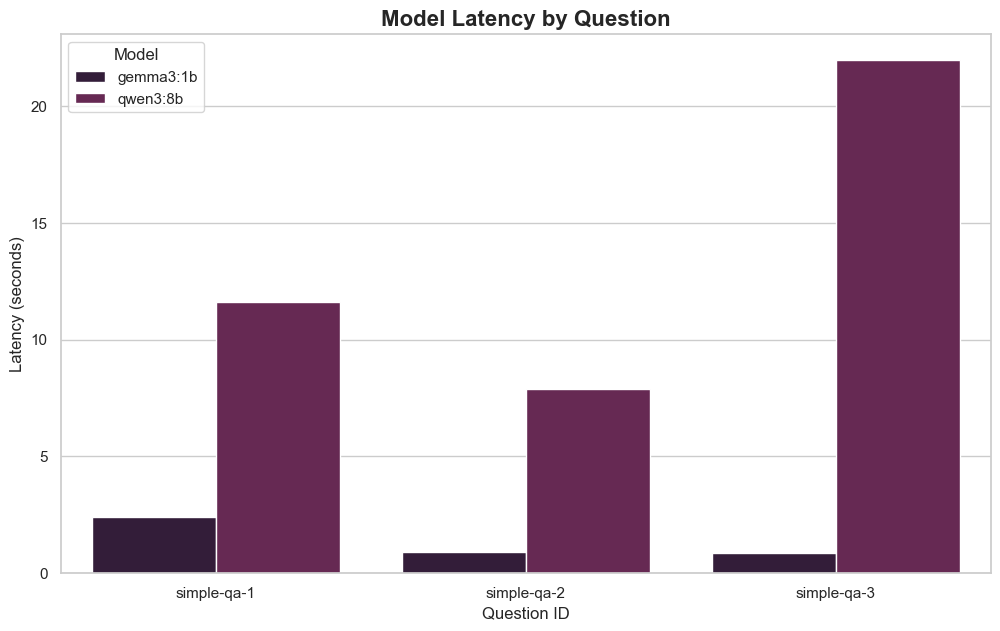

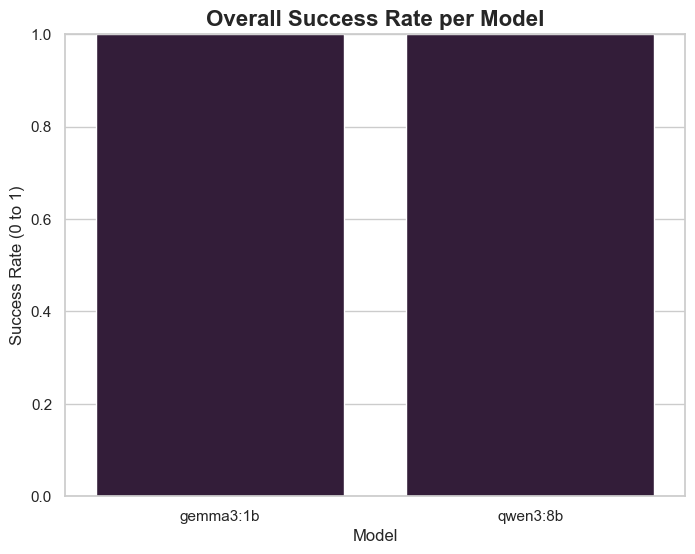

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="rocket")

if not df.empty:
    # --- Latency Comparison ---
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df, x="question_id", y="latency", hue="model")
    plt.title("Model Latency by Question", fontsize=16, fontweight='bold')
    plt.ylabel("Latency (seconds)", fontsize=12)
    plt.xlabel("Question ID", fontsize=12)
    plt.legend(title='Model')
    plt.show()

    # --- Success Rate Comparison ---
    success_rate = df.groupby('model')['success'].mean().reset_index()
    plt.figure(figsize=(8, 6))
    sns.barplot(data=success_rate, x="model", y="success")
    plt.title("Overall Success Rate per Model", fontsize=16, fontweight='bold')
    plt.ylabel("Success Rate (0 to 1)", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.ylim(0, 1)
    plt.show()
else:
    print("DataFrame is empty. Cannot generate plots. Did the experiment fail to run?")

## 5. Conclusion

The experiment shows that both models successfully handled all simple chat requests. However, gemma3:1b consistently demonstrated lower latency compared to qwen3:8b. This is expected, as gemma3:1b is a smaller model, which often translates to faster processing for less complex tasks like simple chat.

Recommendation: For simple chat scenarios where speed is a priority and the complexity of the query is low, gemma3:1b appears to be the faster choice based on these results. For tasks requiring more complex reasoning or tool use, the larger qwen3:8b might be more suitable (though this experiment did not test tool use).